In [2]:
#import sys
#!{sys.executable} -m pip install imblearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import SelectKBest
from collections import Counter

import matplotlib.ticker as mtick #for showing percentage in it

In [2]:
data=pd.read_csv(r'C:\Users\tusha\Documents\Data Science\Python\Telco Customer Churn\WA_Fn-UseC_-Telco-Customer-Churn.csv')
data_backup=data.copy()
data.head()
'''
https://www.kaggle.com/datasets/blastchar/telco-customer-churn
'''
#dataset information

'\nhttps://www.kaggle.com/datasets/blastchar/telco-customer-churn\n'

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
data['TotalCharges']=pd.to_numeric(data['TotalCharges'],errors='coerce')
data['MonthlyCharges']=pd.to_numeric(data['TotalCharges'],errors='coerce')

In [5]:
data.iloc[:,-3:-1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MonthlyCharges  7032 non-null   float64
 1   TotalCharges    7032 non-null   float64
dtypes: float64(2)
memory usage: 110.2 KB


In [6]:
numerical_feature=[feature for feature in data.columns if data[feature].dtypes!='O']
print(numerical_feature)

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [7]:
categorical_feature=[feature for feature in data.columns if data[feature].dtypes=='O']
print(f' Length of the categorical features is {len(categorical_feature)} \n and categorical features are {categorical_feature} ')

 Length of the categorical features is 17 
 and categorical features are ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'] 


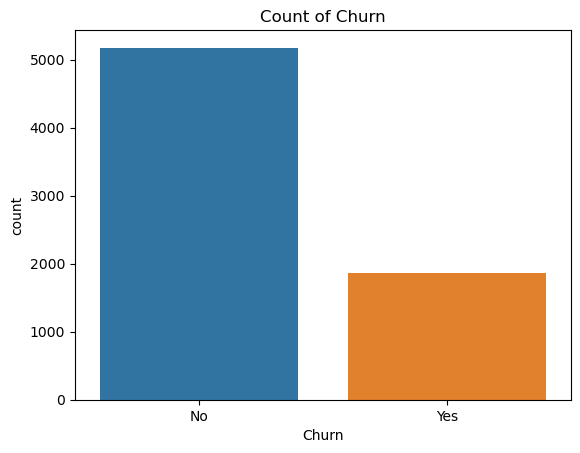

In [8]:
sns.countplot(data=data,x='Churn')
plt.title('Count of Churn')
plt.show()

In [9]:
data['Churn'].value_counts(normalize=True)*100 
#dataset is imbalanced

No     73.463013
Yes    26.536987
Name: Churn, dtype: float64

In [10]:
#finding the loss due to the churn of customers
total_loss =data.loc[data['Churn']=='Yes','TotalCharges'].sum()
print(total_loss)
print('Percentage of revenue lost is approx ',round(total_loss/data['TotalCharges'].sum()*100))

2862926.9
Percentage of revenue lost is approx  18


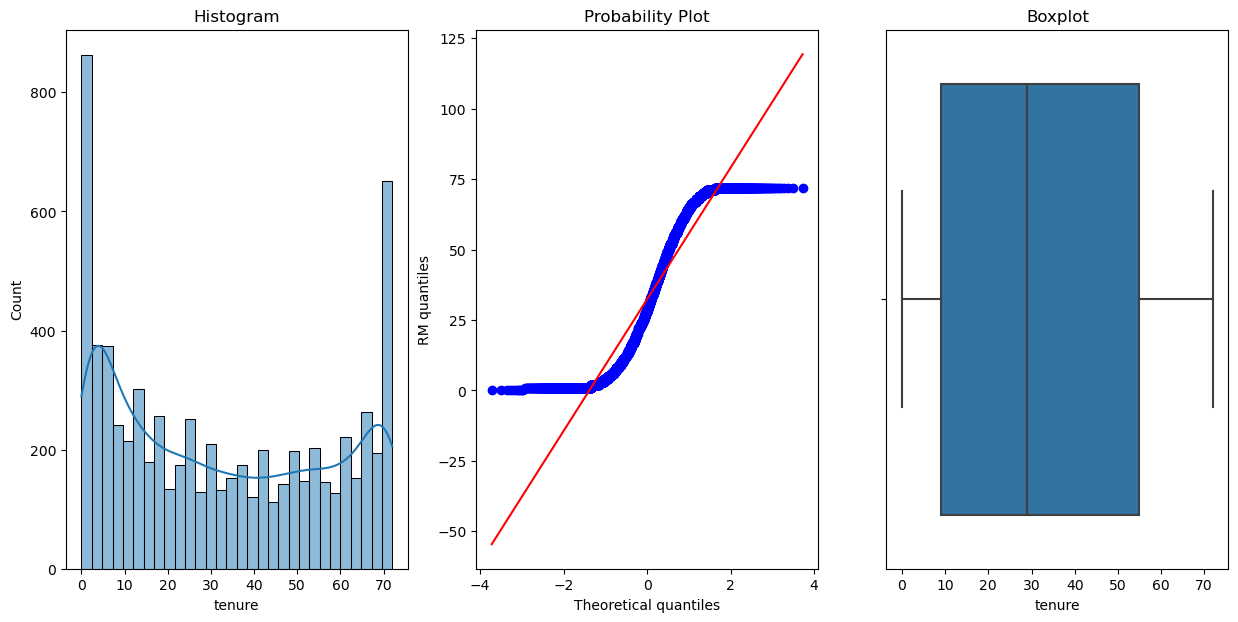

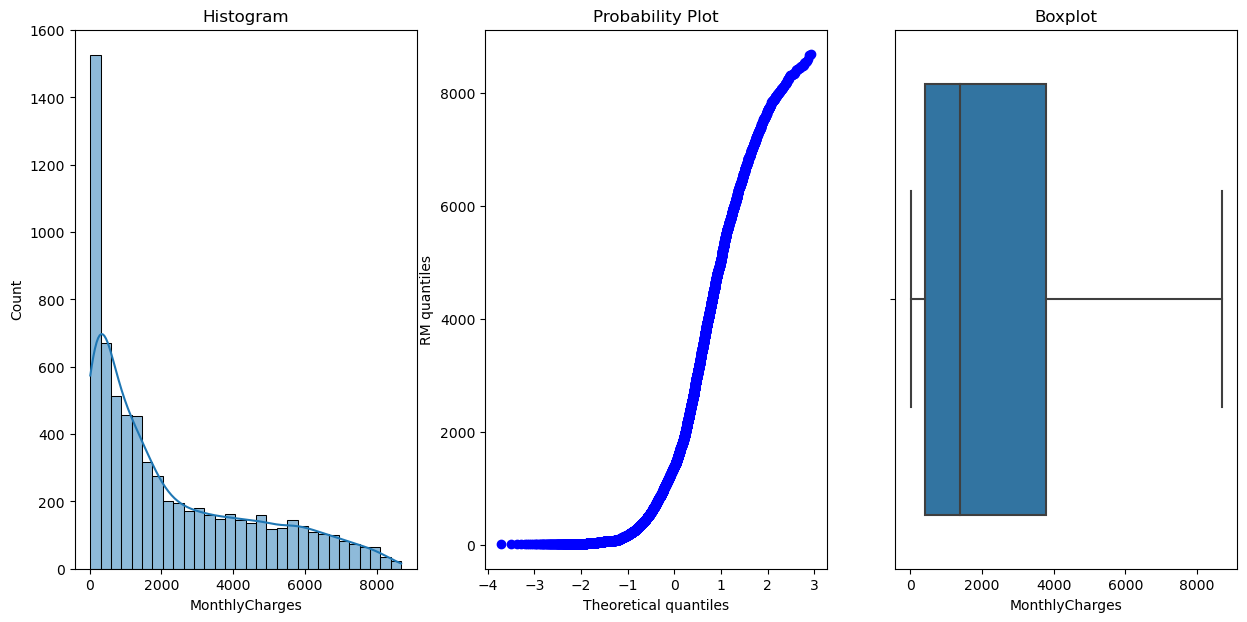

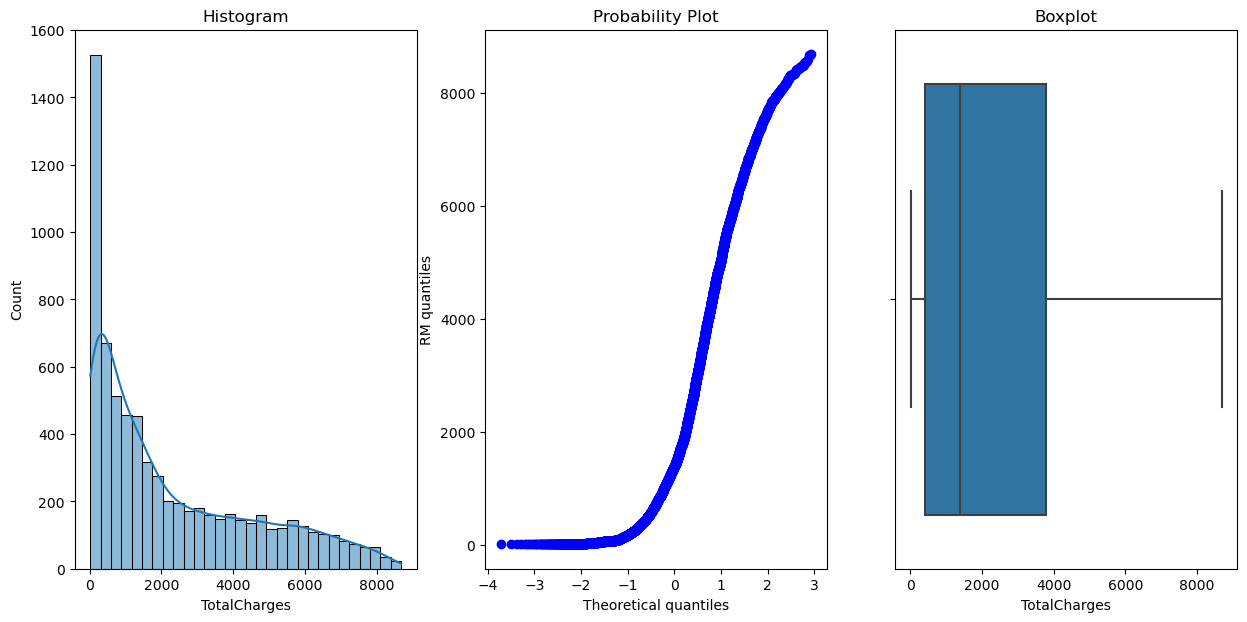

In [11]:
#plotting numerical features with probability distribution and checking outlier
for feature in numerical_feature:
    if feature != 'SeniorCitizen':
        plt.figure(figsize=(15,7))
        
        plt.subplot(1,3,1)
        sns.histplot(data=data,x=feature,bins=30,kde=True)
        plt.title('Histogram')
        
        plt.subplot(1,3,2)
        stats.probplot(data[feature],dist='norm',plot=plt)
        plt.ylabel('RM quantiles')
        
        plt.subplot(1,3,3)
        sns.boxplot(x=data[feature])
        plt.title('Boxplot')
#After ploting histogram probability distribution and box plot to find numerical value are in normally distribution
#and our dataset has no outlier dataset.So, we don't want to remove the outlier in our dataset

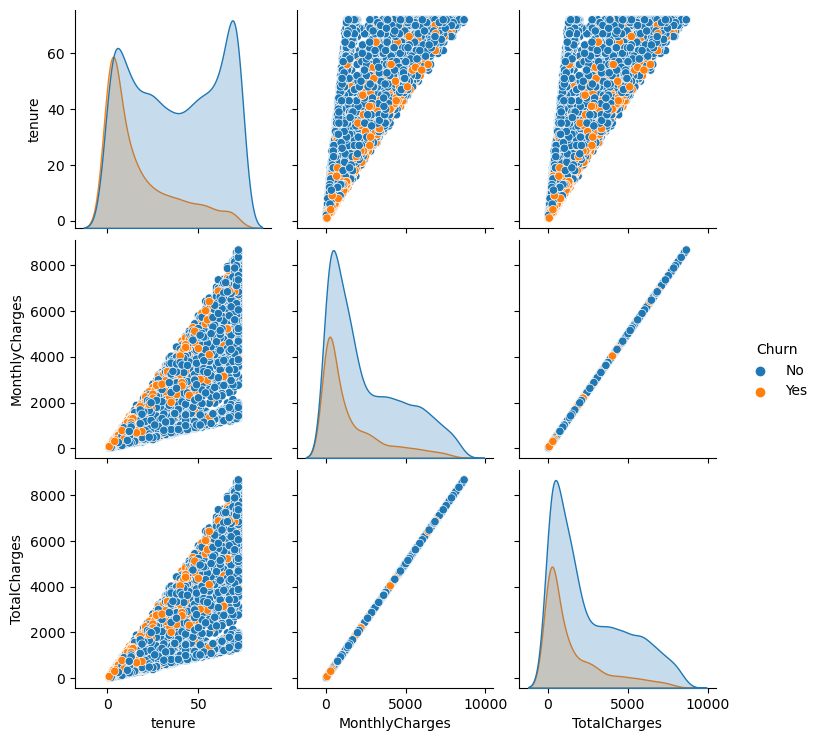

In [12]:
sns.pairplot(data.drop(columns='SeniorCitizen'),hue='Churn',kind='scatter')

<Axes: ylabel='Churn'>

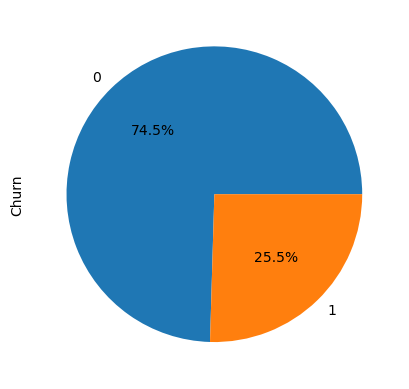

In [14]:
data[data['Churn']=='Yes'].groupby(['SeniorCitizen']).count()['Churn'].plot(kind='pie',autopct='%.1f%%')
# As we can clearly see around 25.5% of people who left are SenoorCitizens

<Figure size 640x480 with 0 Axes>

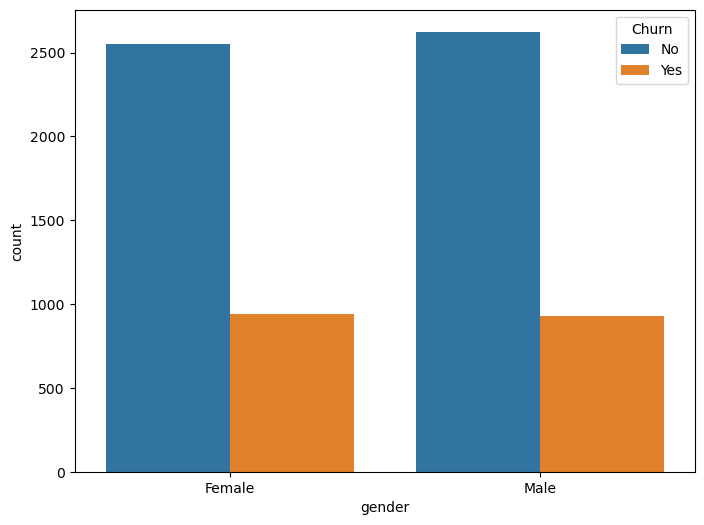

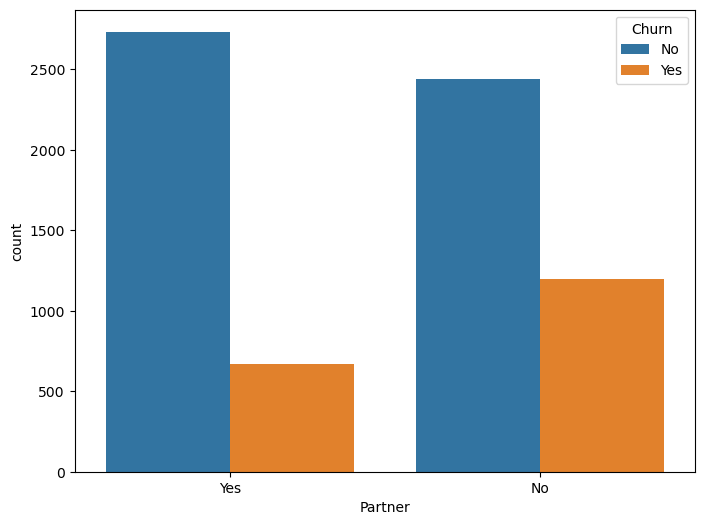

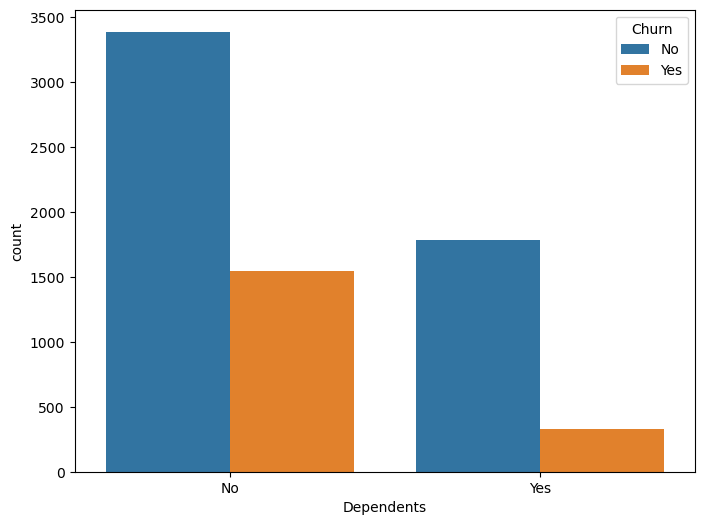

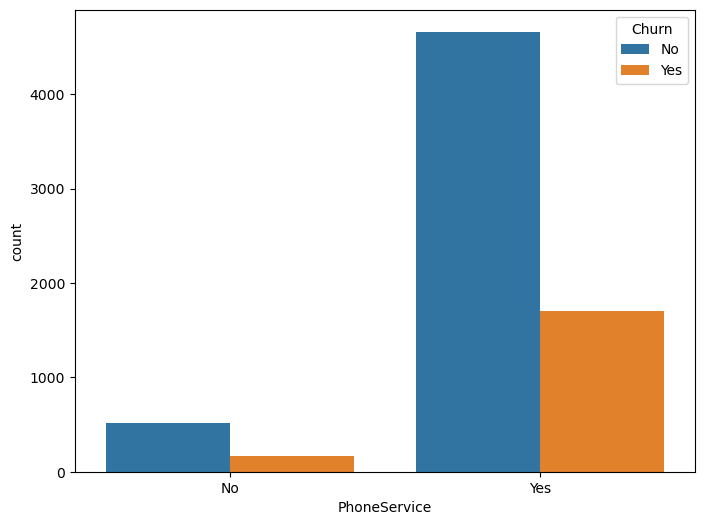

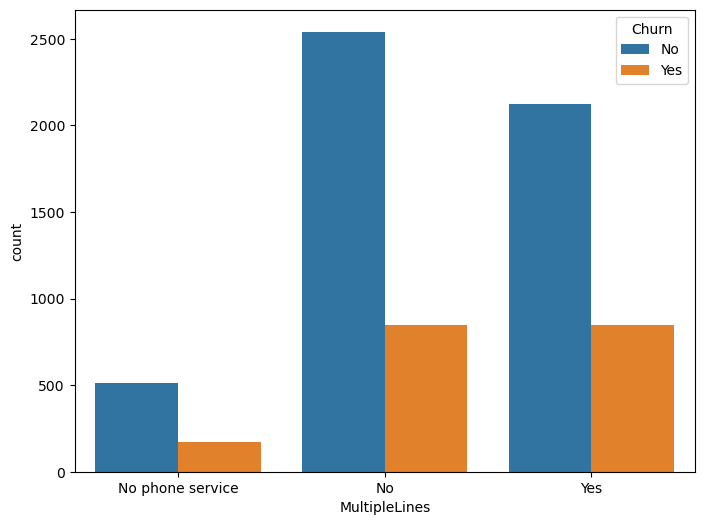

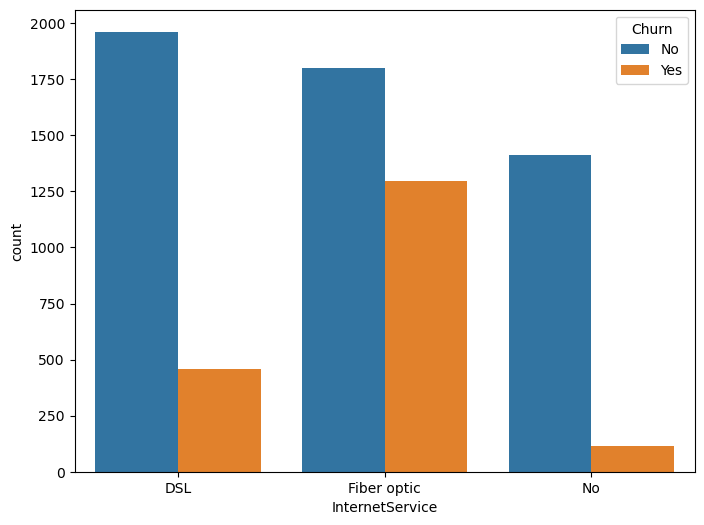

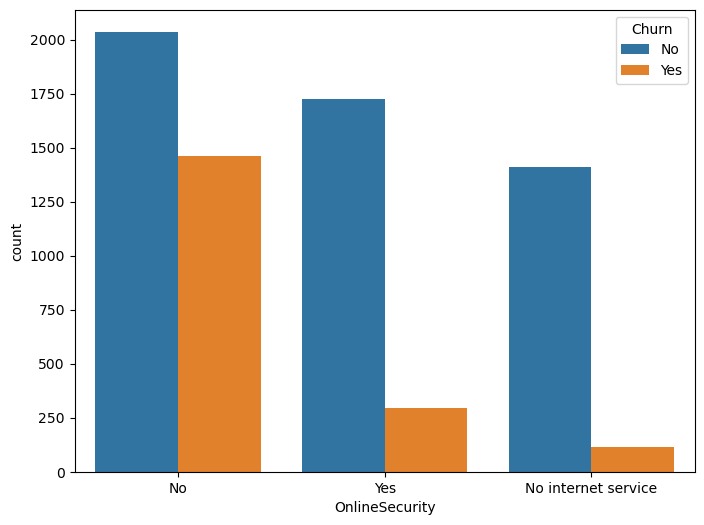

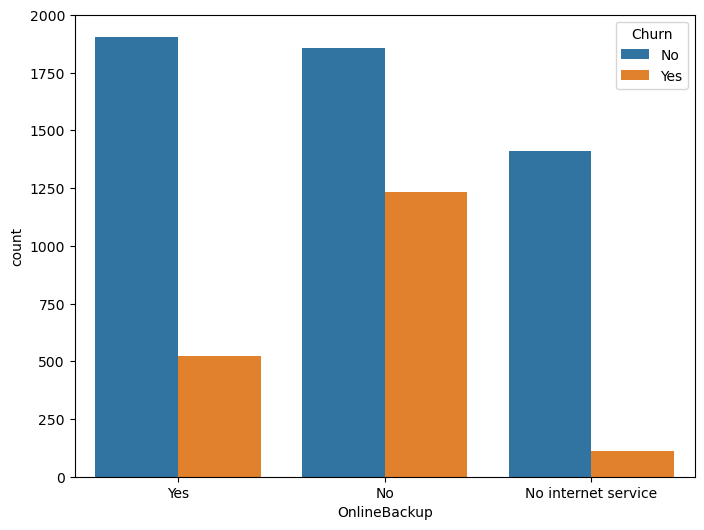

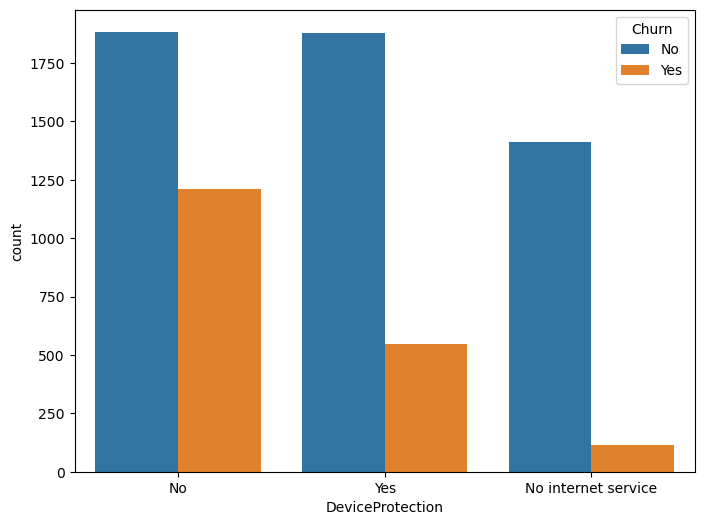

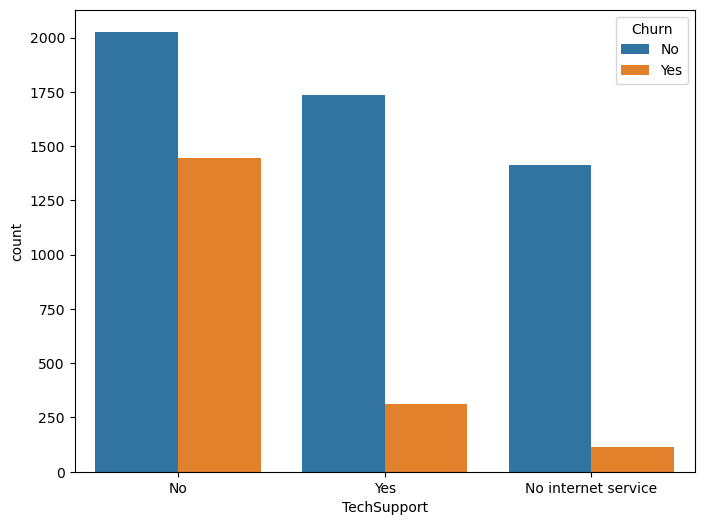

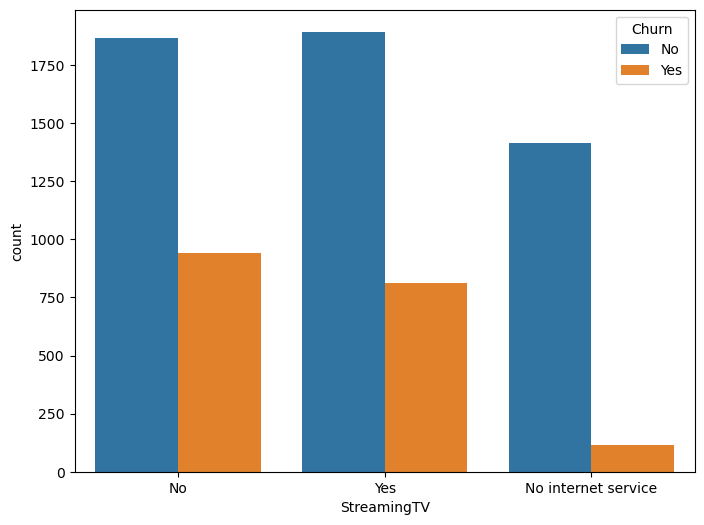

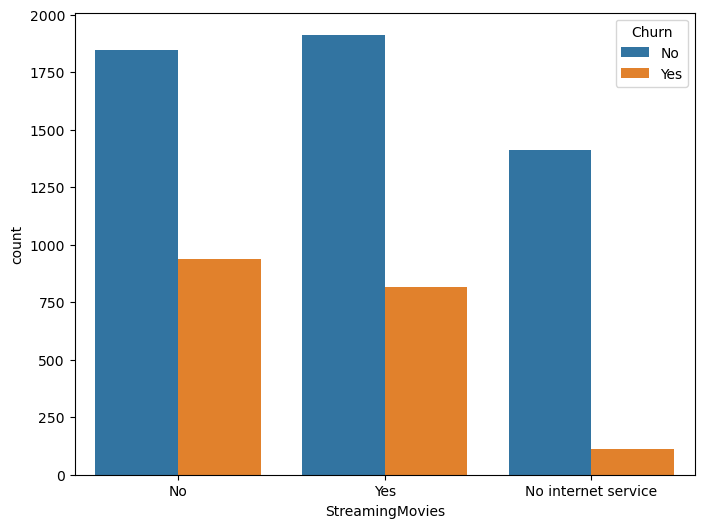

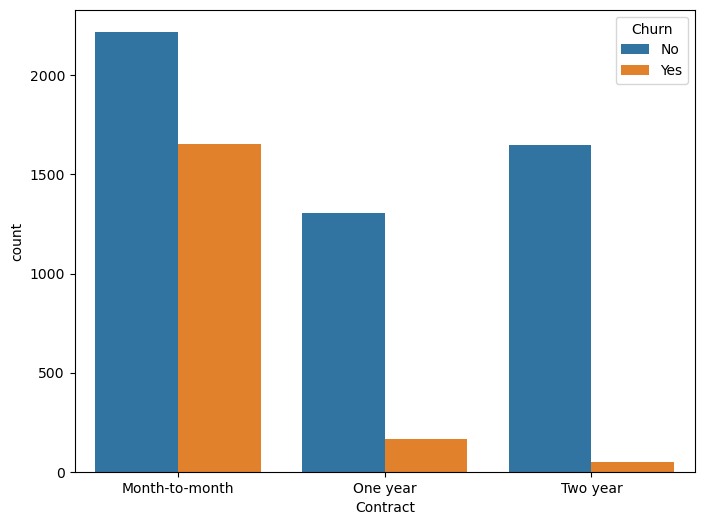

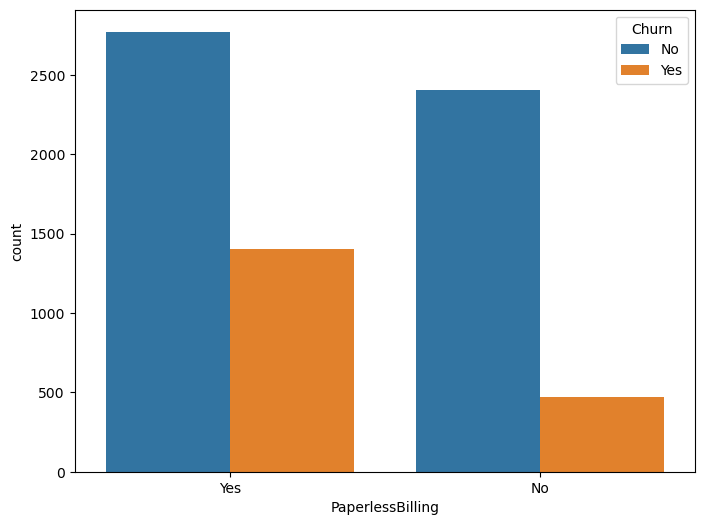

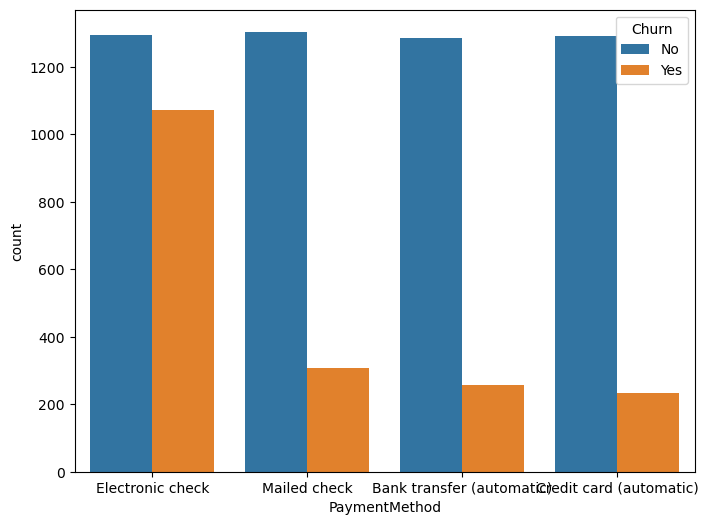

In [15]:
for i, feature in enumerate(categorical_feature):
    if feature not in ['TotalCharges','customerID','Churn']:
            plt.figure(i)
            plt.figure(figsize=(8,6))
            sns.countplot(data=data, x=feature, hue='Churn')
plt.show()

In [16]:
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges      11
TotalCharges        11
Churn                0
dtype: int64

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp_mean = IterativeImputer(random_state=101)
data[['MonthlyCharges','TotalCharges']]=imp_mean.fit_transform(data[['MonthlyCharges','TotalCharges']])

In [18]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [19]:
categorical_feature

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [20]:
data.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


In [21]:
categorical_feature.append('SeniorCitizen')


In [22]:
numerical_feature.remove('SeniorCitizen')

In [23]:
encoder=LabelEncoder()
for feature in categorical_feature:
    data[feature]=encoder.fit_transform(data[feature])

In [24]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5375,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,3962,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,1889.50,1889.50,0
2,2564,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,108.15,108.15,1
3,5535,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,1840.75,1840.75,0
4,6511,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,151.65,151.65,1


<Axes: >

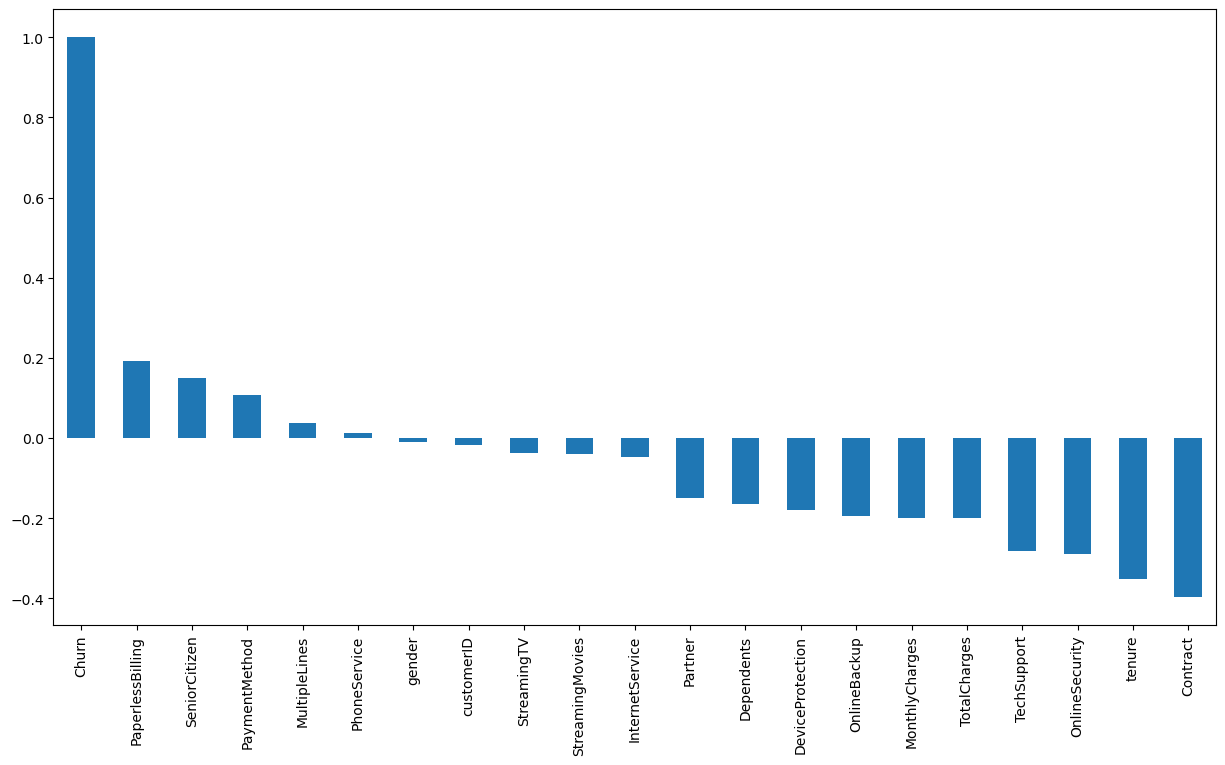

In [25]:
plt.figure(figsize=(15,8))
data.corr()['Churn'].sort_values(ascending=False).plot(kind='bar')

<Axes: >

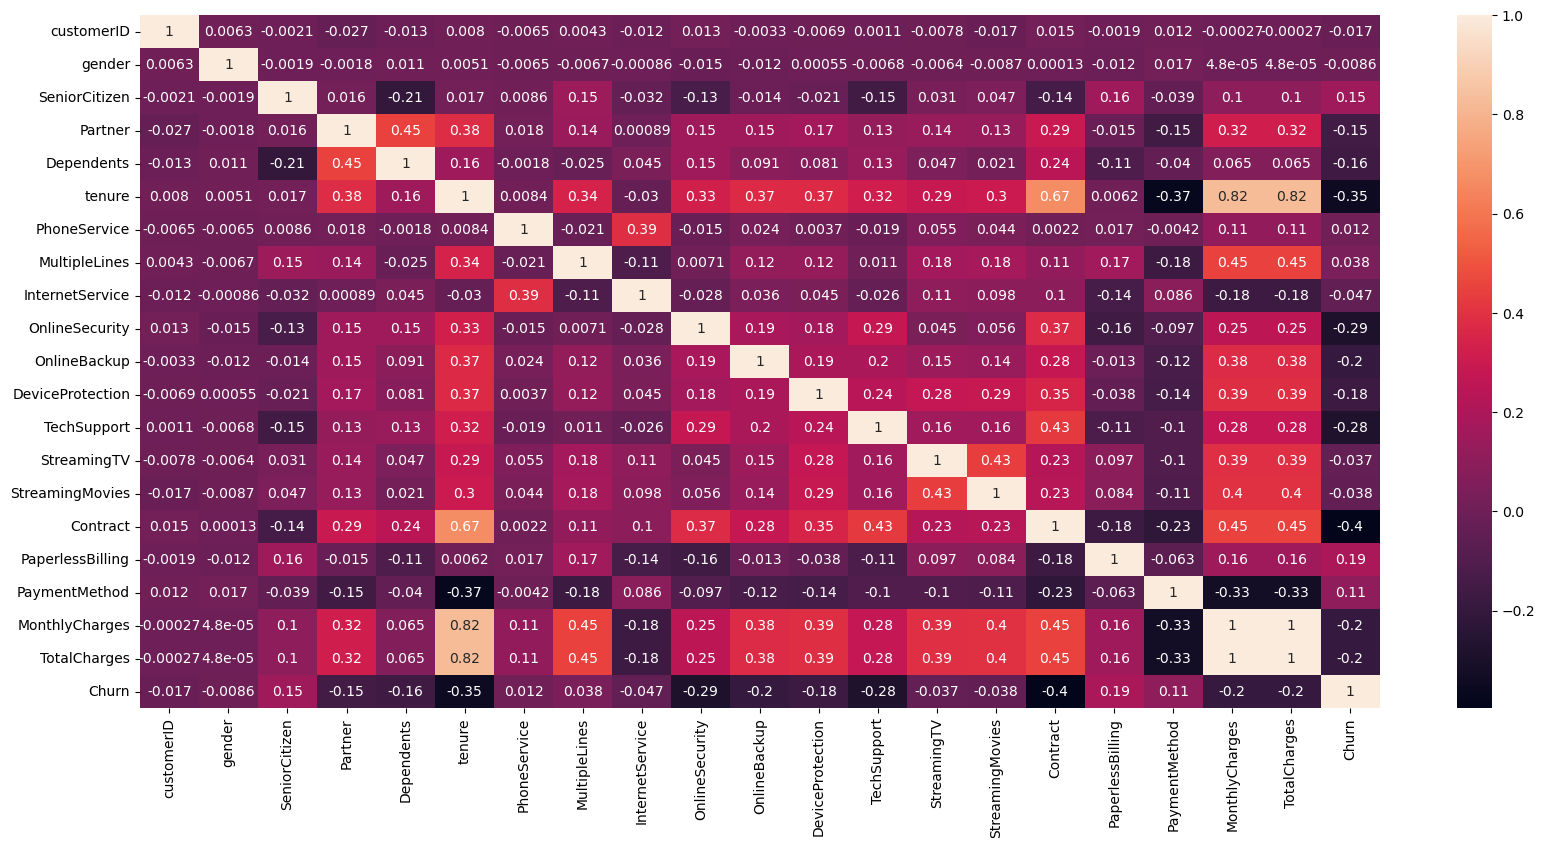

In [26]:
plt.figure(figsize=(20,9))
sns.heatmap(data.corr(),annot=True)

In [27]:
X=data.drop(columns=['Churn','customerID'])
y=data['Churn']
#Iam using ensemble methods, No need to perform feature scaling for ensemble techniques,
#its prediction based on the creating multiple decision trees
#also dropping customerId since it is of no use

In [28]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,1889.50,1889.50
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,108.15,108.15
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,1840.75,1840.75
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,151.65,151.65


In [29]:
from sklearn.ensemble import RandomForestClassifier
pmodel=RandomForestClassifier(random_state=0,n_jobs=-1)
pmodel.fit(X,y)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [30]:
from sklearn.inspection import permutation_importance
perm=permutation_importance(pmodel,X,y,n_repeats=10,n_jobs=-1)

In [31]:
perm.importances_mean

array([0.02684935, 0.02121255, 0.02185148, 0.01764873, 0.09162289,
       0.00400398, 0.04063609, 0.07576317, 0.0500355 , 0.02794264,
       0.02298736, 0.04749397, 0.03641914, 0.02895073, 0.09877893,
       0.04490984, 0.05541673, 0.05371291, 0.05952009])

In [73]:
feature_importances=pd.Series(data=perm.importances_mean,index=X.columns)
print(feature_importances.sort_values(ascending=False))

Contract            0.098779
tenure              0.091623
InternetService     0.075763
TotalCharges        0.059520
PaymentMethod       0.055417
MonthlyCharges      0.053713
OnlineSecurity      0.050035
TechSupport         0.047494
PaperlessBilling    0.044910
MultipleLines       0.040636
StreamingTV         0.036419
StreamingMovies     0.028951
OnlineBackup        0.027943
gender              0.026849
DeviceProtection    0.022987
Partner             0.021851
SeniorCitizen       0.021213
Dependents          0.017649
PhoneService        0.004004
dtype: float64


In [33]:
top10features = feature_importances.sort_values(ascending=False)[0:10].index
#X_columns=feature_importances.index
X_columns=X.columns
top10features

Index(['Contract', 'tenure', 'InternetService', 'TotalCharges',
       'PaymentMethod', 'MonthlyCharges', 'OnlineSecurity', 'TechSupport',
       'PaperlessBilling', 'MultipleLines'],
      dtype='object')

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X[top10features], y, test_size=0.2)


In [35]:
print(X_train.shape)
print(y_train.shape)

(5634, 10)
(5634,)


In [36]:
Log_reg = LogisticRegression(C=150, max_iter=150)
Log_reg.fit(X_train, y_train)
log_pred = Log_reg.predict(X_test)

print(f'Accuracy score : {accuracy_score(log_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(log_pred, y_test)}')
print(f'Classification report :\n {classification_report(log_pred, y_test)}')

Accuracy score : 0.794180269694819
Confusion matrix :
 [[917 176]
 [114 202]]
Classification report :
               precision    recall  f1-score   support

           0       0.89      0.84      0.86      1093
           1       0.53      0.64      0.58       316

    accuracy                           0.79      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.81      0.79      0.80      1409



In [37]:
# Random forest classifier
Rfc = RandomForestClassifier(n_estimators=120,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=5)
Rfc.fit(X_train, y_train)
rfc_pred = Rfc.predict(X_test)

print(f'Accuracy score : {accuracy_score(rfc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_pred, y_test)}')
print(f'Classification report :\n {classification_report(rfc_pred, y_test)}')

Accuracy score : 0.7927608232789212
Confusion matrix :
 [[926 187]
 [105 191]]
Classification report :
               precision    recall  f1-score   support

           0       0.90      0.83      0.86      1113
           1       0.51      0.65      0.57       296

    accuracy                           0.79      1409
   macro avg       0.70      0.74      0.72      1409
weighted avg       0.82      0.79      0.80      1409



In [38]:
# decisionTree Classifier
Dtc = DecisionTreeClassifier(criterion='gini', splitter='random', min_samples_leaf=15)
Dtc.fit(X_train, y_train)
dtc_pred = Dtc.predict(X_test)

print(f'Accuracy score : {accuracy_score(dtc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_pred, y_test)}')
print(f'Classification report :\n {classification_report(dtc_pred, y_test)}')

Accuracy score : 0.794180269694819
Confusion matrix :
 [[926 185]
 [105 193]]
Classification report :
               precision    recall  f1-score   support

           0       0.90      0.83      0.86      1111
           1       0.51      0.65      0.57       298

    accuracy                           0.79      1409
   macro avg       0.70      0.74      0.72      1409
weighted avg       0.82      0.79      0.80      1409



In [39]:
tc = DecisionTreeClassifier(criterion='gini', splitter='random', min_samples_leaf=15)
Dtc.fit(X_train, y_train)
dtc_pred = Dtc.predict(X_test)

print(f'Accuracy score : {accuracy_score(dtc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_pred, y_test)}')
print(f'Classification report :\n {classification_report(dtc_pred, y_test)}')

Accuracy score : 0.7877927608232789
Confusion matrix :
 [[908 176]
 [123 202]]
Classification report :
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      1084
           1       0.53      0.62      0.57       325

    accuracy                           0.79      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.80      0.79      0.79      1409



In [70]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
pred = gbc.predict(X_test)

print(f'Accuracy score : {accuracy_score(pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test)}')
print(f'Classification report :\n {classification_report(pred, y_test)}')
from sklearn import metrics
y_proba =gbc_optm.predict_proba(X_test)[:,1]
auc=metrics.roc_auc_score(y_test,y_proba)
print(auc)

Accuracy score : 0.7920511000709723
Confusion matrix :
 [[921 183]
 [110 195]]
Classification report :
               precision    recall  f1-score   support

           0       0.89      0.83      0.86      1104
           1       0.52      0.64      0.57       305

    accuracy                           0.79      1409
   macro avg       0.70      0.74      0.72      1409
weighted avg       0.81      0.79      0.80      1409

0.8169984450294827


In [48]:
#balancing the class
st=SMOTEENN(random_state=101)
X_train_st,y_train_st = st.fit_resample(X_train,y_train)
print(f'The number of classes before fit is {Counter(y_train)}')
print(f'The number of classes after fit is {Counter(y_train_st)}')

The number of classes before fit is Counter({0: 4143, 1: 1491})
The number of classes after fit is Counter({1: 2479, 0: 2048})


In [49]:
# splitting the over sampling dataset 
X_train_sap, X_test_sap, y_train_sap, y_test_sap = train_test_split(X_train_st, y_train_st, test_size=0.2)

In [50]:
# decisionTree Classifier
Dtc_sampling = DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=7, min_samples_leaf=15)
Dtc_sampling.fit(X_train_sap, y_train_sap)
dtc_sampling_pred = Dtc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(dtc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(dtc_sampling_pred, y_test_sap)}')

Accuracy score : 0.9072847682119205
Confusion matrix :
 [[367  30]
 [ 54 455]]
Classification report :
               precision    recall  f1-score   support

           0       0.87      0.92      0.90       397
           1       0.94      0.89      0.92       509

    accuracy                           0.91       906
   macro avg       0.90      0.91      0.91       906
weighted avg       0.91      0.91      0.91       906



In [51]:
# Random forest classifier
Rfc_sampling = RandomForestClassifier(n_estimators=150,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=6)
Rfc_sampling.fit(X_train_sap, y_train_sap)
rfc_sampling_pred = Rfc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(rfc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(rfc_sampling_pred, y_test_sap)}')

Accuracy score : 0.9216335540838853
Confusion matrix :
 [[375  25]
 [ 46 460]]
Classification report :
               precision    recall  f1-score   support

           0       0.89      0.94      0.91       400
           1       0.95      0.91      0.93       506

    accuracy                           0.92       906
   macro avg       0.92      0.92      0.92       906
weighted avg       0.92      0.92      0.92       906



In [52]:
# logistic regression
Log_reg_sampling = LogisticRegression(C=10, max_iter=150)
Log_reg_sampling.fit(X_train_sap, y_train_sap)
Log_sampling_pred = Log_reg_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(Log_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(Log_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(Log_sampling_pred, y_test_sap)}')

Accuracy score : 0.9094922737306843
Confusion matrix :
 [[366  27]
 [ 55 458]]
Classification report :
               precision    recall  f1-score   support

           0       0.87      0.93      0.90       393
           1       0.94      0.89      0.92       513

    accuracy                           0.91       906
   macro avg       0.91      0.91      0.91       906
weighted avg       0.91      0.91      0.91       906



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [53]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_sap, y_train_sap)
pred = gbc.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(pred, y_test_sap)}')

Accuracy score : 0.9326710816777042
Confusion matrix :
 [[384  24]
 [ 37 461]]
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.94      0.93       408
           1       0.95      0.93      0.94       498

    accuracy                           0.93       906
   macro avg       0.93      0.93      0.93       906
weighted avg       0.93      0.93      0.93       906



After using SMOOTEENN methods to perform over sampling and down sampling with edited nearest neighbours. From this results we get bet accuraccy and TP FP ratio also increases in GradientBoostClassifier so perform HyperParameter Tunning for this model only

In [54]:
param_grid = {'n_estimators':[100, 150, 200, 250, 300],
             'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
             'min_samples_split': [2,3,4,5,6,7,8,9,10],
             'min_samples_leaf': [1,3,5,7,9,11,13,15],'max_leaf_nodes': [3,6,8,9,12,15,18,24],
              'max_depth': [3,5,7,9,11,13,15,17,19],
              'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
              'loss': ['deviance', 'exponential']
              }

In [55]:
gbc_optm = RandomizedSearchCV(estimator=gbc, param_distributions=param_grid,n_iter=100, verbose=3)
gbc_optm.fit(X_train_sap, y_train_sap)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END criterion=mae, learning_rate=0.05, loss=deviance, max_depth=7, max_leaf_nodes=6, min_samples_leaf=11, min_samples_split=5, n_estimators=300;, score=nan total time=   0.0s
[CV 2/5] END criterion=mae, learning_rate=0.05, loss=deviance, max_depth=7, max_leaf_nodes=6, min_samples_leaf=11, min_samples_split=5, n_estimators=300;, score=nan total time=   0.0s
[CV 3/5] END criterion=mae, learning_rate=0.05, loss=deviance, max_depth=7, max_leaf_nodes=6, min_samples_leaf=11, min_samples_split=5, n_estimators=300;, score=nan total time=   0.0s
[CV 4/5] END criterion=mae, learning_rate=0.05, loss=deviance, max_depth=7, max_leaf_nodes=6, min_samples_leaf=11, min_samples_split=5, n_estimators=300;, score=nan total time=   0.0s
[CV 5/5] END criterion=mae, learning_rate=0.05, loss=deviance, max_depth=7, max_leaf_nodes=6, min_samples_leaf=11, min_samples_split=5, n_estimators=300;, score=nan total time=   0.0s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=squared_error, learning_rate=0.3, loss=deviance, max_depth=15, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.950 total time=   0.5s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=squared_error, learning_rate=0.3, loss=deviance, max_depth=15, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.963 total time=   0.5s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=squared_error, learning_rate=0.3, loss=deviance, max_depth=15, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.960 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=squared_error, learning_rate=0.3, loss=deviance, max_depth=15, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.967 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=squared_error, learning_rate=0.3, loss=deviance, max_depth=15, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.972 total time=   0.5s
[CV 1/5] END criterion=mse, learning_rate=0.3, loss=exponential, max_depth=3, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6, n_estimators=300;, score=nan total time=   0.0s
[CV 2/5] END criterion=mse, learning_rate=0.3, loss=exponential, max_depth=3, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6, n_estimators=300;, score=nan total time=   0.0s
[CV 3/5] END criterion=mse, learning_rate=0.3, loss=exponential, max_depth=3, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6, n_estimators=300;, score=nan total time=   0.0s
[CV 4/5] END criterion=mse, learning_rate=0.3, loss=exponential, max_depth=3, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6, n_estimators=300;, score=nan total time=   0.0s
[CV 5/5] END criterion=mse, learning_rate=0.3, loss=exponential, 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=9, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.938 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=9, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.954 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=9, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.948 total time=   0.5s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=9, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.960 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=9, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.960 total time=   0.6s
[CV 1/5] END criterion=friedman_mse, learning_rate=0.4, loss=exponential, max_depth=19, max_leaf_nodes=15, min_samples_leaf=7, min_samples_split=8, n_estimators=250;, score=0.949 total time=   1.5s
[CV 2/5] END criterion=friedman_mse, learning_rate=0.4, loss=exponential, max_depth=19, max_leaf_nodes=15, min_samples_leaf=7, min_samples_split=8, n_estimators=250;, score=0.960 total time=   1.3s
[CV 3/5] END criterion=friedman_mse, learning_rate=0.4, loss=exponential, max_depth=19, max_leaf_nodes=15, min_samples_leaf=7, min_samples_split=8, n_estimators=250;, score=0.964 total time=   1.3s
[CV 4/5] END criterion=friedman_mse, learning_rate=0.4, loss=exponential, max_depth=19, max_leaf_nodes=15, min_samples_leaf=7, min_samples_split=8, n_estimators=250;, score=0.965 total time=   1.5s
[CV 5/5] END c

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=7, max_leaf_nodes=12, min_samples_leaf=15, min_samples_split=3, n_estimators=200;, score=0.943 total time=   1.1s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=7, max_leaf_nodes=12, min_samples_leaf=15, min_samples_split=3, n_estimators=200;, score=0.963 total time=   1.1s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=7, max_leaf_nodes=12, min_samples_leaf=15, min_samples_split=3, n_estimators=200;, score=0.956 total time=   1.2s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=7, max_leaf_nodes=12, min_samples_leaf=15, min_samples_split=3, n_estimators=200;, score=0.959 total time=   1.1s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=7, max_leaf_nodes=12, min_samples_leaf=15, min_samples_split=3, n_estimators=200;, score=0.959 total time=   1.1s
[CV 1/5] END criterion=friedman_mse, learning_rate=0.2, loss=exponential, max_depth=15, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=3, n_estimators=300;, score=0.949 total time=   1.2s
[CV 2/5] END criterion=friedman_mse, learning_rate=0.2, loss=exponential, max_depth=15, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=3, n_estimators=300;, score=0.967 total time=   1.2s
[CV 3/5] END criterion=friedman_mse, learning_rate=0.2, loss=exponential, max_depth=15, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=3, n_estimators=300;, score=0.963 total time=   1.2s
[CV 4/5] END criterion=friedman_mse, learning_rate=0.2, loss=exponential, max_depth=15, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=3, n_estimators=300;, score=0.970 total time=   1.2s
[CV 5/5] END cri

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=squared_error, learning_rate=0.2, loss=deviance, max_depth=17, max_leaf_nodes=8, min_samples_leaf=15, min_samples_split=10, n_estimators=100;, score=0.937 total time=   0.4s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=squared_error, learning_rate=0.2, loss=deviance, max_depth=17, max_leaf_nodes=8, min_samples_leaf=15, min_samples_split=10, n_estimators=100;, score=0.952 total time=   0.4s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=squared_error, learning_rate=0.2, loss=deviance, max_depth=17, max_leaf_nodes=8, min_samples_leaf=15, min_samples_split=10, n_estimators=100;, score=0.948 total time=   0.4s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=squared_error, learning_rate=0.2, loss=deviance, max_depth=17, max_leaf_nodes=8, min_samples_leaf=15, min_samples_split=10, n_estimators=100;, score=0.946 total time=   0.4s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=squared_error, learning_rate=0.2, loss=deviance, max_depth=17, max_leaf_nodes=8, min_samples_leaf=15, min_samples_split=10, n_estimators=100;, score=0.956 total time=   0.4s
[CV 1/5] END criterion=mse, learning_rate=0.2, loss=deviance, max_depth=17, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=9, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END criterion=mse, learning_rate=0.2, loss=deviance, max_depth=17, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=9, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END criterion=mse, learning_rate=0.2, loss=deviance, max_depth=17, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=9, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5] END criterion=mse, learning_rate=0.2, loss=deviance, max_depth=17, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=9, n_estimators=100;, score=nan total time=   0.0s
[CV 5/5] END criterion=mse, learning_rate=0.2, loss=deviance, max_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=friedman_mse, learning_rate=0.3, loss=deviance, max_depth=13, max_leaf_nodes=18, min_samples_leaf=9, min_samples_split=3, n_estimators=100;, score=0.959 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=friedman_mse, learning_rate=0.3, loss=deviance, max_depth=13, max_leaf_nodes=18, min_samples_leaf=9, min_samples_split=3, n_estimators=100;, score=0.963 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=friedman_mse, learning_rate=0.3, loss=deviance, max_depth=13, max_leaf_nodes=18, min_samples_leaf=9, min_samples_split=3, n_estimators=100;, score=0.964 total time=   0.5s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=friedman_mse, learning_rate=0.3, loss=deviance, max_depth=13, max_leaf_nodes=18, min_samples_leaf=9, min_samples_split=3, n_estimators=100;, score=0.971 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=friedman_mse, learning_rate=0.3, loss=deviance, max_depth=13, max_leaf_nodes=18, min_samples_leaf=9, min_samples_split=3, n_estimators=100;, score=0.965 total time=   0.6s
[CV 1/5] END criterion=mse, learning_rate=0.5, loss=exponential, max_depth=15, max_leaf_nodes=18, min_samples_leaf=15, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 2/5] END criterion=mse, learning_rate=0.5, loss=exponential, max_depth=15, max_leaf_nodes=18, min_samples_leaf=15, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 3/5] END criterion=mse, learning_rate=0.5, loss=exponential, max_depth=15, max_leaf_nodes=18, min_samples_leaf=15, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 4/5] END criterion=mse, learning_rate=0.5, loss=exponential, max_depth=15, max_leaf_nodes=18, min_samples_leaf=15, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 5/5] END criterion=mse, learning_rate=0.5, loss=e

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=13, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=8, n_estimators=200;, score=0.945 total time=   0.9s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=13, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=8, n_estimators=200;, score=0.964 total time=   0.8s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=13, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=8, n_estimators=200;, score=0.959 total time=   0.8s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=13, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=8, n_estimators=200;, score=0.963 total time=   0.9s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=13, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=8, n_estimators=200;, score=0.959 total time=   0.8s
[CV 1/5] END criterion=mae, learning_rate=0.4, loss=deviance, max_depth=13, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=4, n_estimators=300;, score=nan total time=   0.0s
[CV 2/5] END criterion=mae, learning_rate=0.4, loss=deviance, max_depth=13, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=4, n_estimators=300;, score=nan total time=   0.0s
[CV 3/5] END criterion=mae, learning_rate=0.4, loss=deviance, max_depth=13, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=4, n_estimators=300;, score=nan total time=   0.0s
[CV 4/5] END criterion=mae, learning_rate=0.4, loss=deviance, max_depth=13, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=4, n_estimators=300;, score=nan total time=   0.0s
[CV 5/5] END criterion=mae, learning_rate=0.4, loss=deviance, max_depth=1

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=squared_error, learning_rate=0.5, loss=deviance, max_depth=19, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.950 total time=   0.4s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=squared_error, learning_rate=0.5, loss=deviance, max_depth=19, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.956 total time=   0.4s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=squared_error, learning_rate=0.5, loss=deviance, max_depth=19, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.960 total time=   0.4s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=squared_error, learning_rate=0.5, loss=deviance, max_depth=19, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.967 total time=   0.4s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=squared_error, learning_rate=0.5, loss=deviance, max_depth=19, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.967 total time=   0.3s
[CV 1/5] END criterion=mse, learning_rate=0.5, loss=exponential, max_depth=15, max_leaf_nodes=12, min_samples_leaf=7, min_samples_split=6, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END criterion=mse, learning_rate=0.5, loss=exponential, max_depth=15, max_leaf_nodes=12, min_samples_leaf=7, min_samples_split=6, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END criterion=mse, learning_rate=0.5, loss=exponential, max_depth=15, max_leaf_nodes=12, min_samples_leaf=7, min_samples_split=6, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5] END criterion=mse, learning_rate=0.5, loss=exponential, max_depth=15, max_leaf_nodes=12, min_samples_leaf=7, min_samples_split=6, n_estimators=100;, score=nan total time=   0.0s
[CV 5/5] END criterion=mse, learning_rate=0.5, loss=expon

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=friedman_mse, learning_rate=0.4, loss=deviance, max_depth=17, max_leaf_nodes=18, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.950 total time=   0.7s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=friedman_mse, learning_rate=0.4, loss=deviance, max_depth=17, max_leaf_nodes=18, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.960 total time=   0.7s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=friedman_mse, learning_rate=0.4, loss=deviance, max_depth=17, max_leaf_nodes=18, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.965 total time=   0.7s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=friedman_mse, learning_rate=0.4, loss=deviance, max_depth=17, max_leaf_nodes=18, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.954 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=friedman_mse, learning_rate=0.4, loss=deviance, max_depth=17, max_leaf_nodes=18, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.965 total time=   0.7s
[CV 1/5] END criterion=mse, learning_rate=0.1, loss=exponential, max_depth=17, max_leaf_nodes=3, min_samples_leaf=9, min_samples_split=6, n_estimators=250;, score=nan total time=   0.0s
[CV 2/5] END criterion=mse, learning_rate=0.1, loss=exponential, max_depth=17, max_leaf_nodes=3, min_samples_leaf=9, min_samples_split=6, n_estimators=250;, score=nan total time=   0.0s
[CV 3/5] END criterion=mse, learning_rate=0.1, loss=exponential, max_depth=17, max_leaf_nodes=3, min_samples_leaf=9, min_samples_split=6, n_estimators=250;, score=nan total time=   0.0s
[CV 4/5] END criterion=mse, learning_rate=0.1, loss=exponential, max_depth=17, max_leaf_nodes=3, min_samples_leaf=9, min_samples_split=6, n_estimators=250;, score=nan total time=   0.0s
[CV 5/5] END criterion=mse, learning_rate=0.1, loss=exponenti

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=17, max_leaf_nodes=3, min_samples_leaf=11, min_samples_split=6, n_estimators=200;, score=0.909 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=17, max_leaf_nodes=3, min_samples_leaf=11, min_samples_split=6, n_estimators=200;, score=0.948 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=17, max_leaf_nodes=3, min_samples_leaf=11, min_samples_split=6, n_estimators=200;, score=0.928 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=17, max_leaf_nodes=3, min_samples_leaf=11, min_samples_split=6, n_estimators=200;, score=0.935 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=17, max_leaf_nodes=3, min_samples_leaf=11, min_samples_split=6, n_estimators=200;, score=0.943 total time=   0.5s
[CV 1/5] END criterion=friedman_mse, learning_rate=0.2, loss=exponential, max_depth=11, max_leaf_nodes=3, min_samples_leaf=13, min_samples_split=8, n_estimators=250;, score=0.919 total time=   0.6s
[CV 2/5] END criterion=friedman_mse, learning_rate=0.2, loss=exponential, max_depth=11, max_leaf_nodes=3, min_samples_leaf=13, min_samples_split=8, n_estimators=250;, score=0.954 total time=   0.6s
[CV 3/5] END criterion=friedman_mse, learning_rate=0.2, loss=exponential, max_depth=11, max_leaf_nodes=3, min_samples_leaf=13, min_samples_split=8, n_estimators=250;, score=0.936 total time=   0.6s
[CV 4/5] END criterion=friedman_mse, learning_rate=0.2, loss=exponential, max_depth=11, max_leaf_nodes=3, min_samples_leaf=13, min_samples_split=8, n_estimators=250;, score=0.942 total time=   0.6s
[CV 5/5] END

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, loss=deviance, max_depth=7, max_leaf_nodes=8, min_samples_leaf=9, min_samples_split=6, n_estimators=300;, score=0.950 total time=   1.2s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, loss=deviance, max_depth=7, max_leaf_nodes=8, min_samples_leaf=9, min_samples_split=6, n_estimators=300;, score=0.964 total time=   1.2s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, loss=deviance, max_depth=7, max_leaf_nodes=8, min_samples_leaf=9, min_samples_split=6, n_estimators=300;, score=0.954 total time=   1.2s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, loss=deviance, max_depth=7, max_leaf_nodes=8, min_samples_leaf=9, min_samples_split=6, n_estimators=300;, score=0.961 total time=   1.3s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, loss=deviance, max_depth=7, max_leaf_nodes=8, min_samples_leaf=9, min_samples_split=6, n_estimators=300;, score=0.965 total time=   1.3s
[CV 1/5] END criterion=squared_error, learning_rate=0.5, loss=exponential, max_depth=13, max_leaf_nodes=6, min_samples_leaf=7, min_samples_split=8, n_estimators=300;, score=0.956 total time=   1.0s
[CV 2/5] END criterion=squared_error, learning_rate=0.5, loss=exponential, max_depth=13, max_leaf_nodes=6, min_samples_leaf=7, min_samples_split=8, n_estimators=300;, score=0.968 total time=   1.0s
[CV 3/5] END criterion=squared_error, learning_rate=0.5, loss=exponential, max_depth=13, max_leaf_nodes=6, min_samples_leaf=7, min_samples_split=8, n_estimators=300;, score=0.965 total time=   1.0s
[CV 4/5] END criterion=squared_error, learning_rate=0.5, loss=exponential, max_depth=13, max_leaf_nodes=6, min_samples_leaf=7, min_samples_split=8, n_estimators=300;, score=0.972 total time=   1.0s
[CV 5/5] END cr

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=friedman_mse, learning_rate=0.05, loss=deviance, max_depth=3, max_leaf_nodes=3, min_samples_leaf=13, min_samples_split=7, n_estimators=250;, score=0.908 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=friedman_mse, learning_rate=0.05, loss=deviance, max_depth=3, max_leaf_nodes=3, min_samples_leaf=13, min_samples_split=7, n_estimators=250;, score=0.945 total time=   0.7s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=friedman_mse, learning_rate=0.05, loss=deviance, max_depth=3, max_leaf_nodes=3, min_samples_leaf=13, min_samples_split=7, n_estimators=250;, score=0.921 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=friedman_mse, learning_rate=0.05, loss=deviance, max_depth=3, max_leaf_nodes=3, min_samples_leaf=13, min_samples_split=7, n_estimators=250;, score=0.923 total time=   0.7s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=friedman_mse, learning_rate=0.05, loss=deviance, max_depth=3, max_leaf_nodes=3, min_samples_leaf=13, min_samples_split=7, n_estimators=250;, score=0.941 total time=   0.7s
[CV 1/5] END criterion=friedman_mse, learning_rate=0.05, loss=exponential, max_depth=13, max_leaf_nodes=9, min_samples_leaf=11, min_samples_split=10, n_estimators=150;, score=0.920 total time=   0.6s
[CV 2/5] END criterion=friedman_mse, learning_rate=0.05, loss=exponential, max_depth=13, max_leaf_nodes=9, min_samples_leaf=11, min_samples_split=10, n_estimators=150;, score=0.959 total time=   0.6s
[CV 3/5] END criterion=friedman_mse, learning_rate=0.05, loss=exponential, max_depth=13, max_leaf_nodes=9, min_samples_leaf=11, min_samples_split=10, n_estimators=150;, score=0.939 total time=   0.6s
[CV 4/5] END criterion=friedman_mse, learning_rate=0.05, loss=exponential, max_depth=13, max_leaf_nodes=9, min_samples_leaf=11, min_samples_split=10, n_estimators=150;, score=0.941 total time=   0.6s
[CV 5

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=friedman_mse, learning_rate=0.4, loss=deviance, max_depth=9, max_leaf_nodes=24, min_samples_leaf=11, min_samples_split=2, n_estimators=100;, score=0.952 total time=   0.7s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=friedman_mse, learning_rate=0.4, loss=deviance, max_depth=9, max_leaf_nodes=24, min_samples_leaf=11, min_samples_split=2, n_estimators=100;, score=0.971 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=friedman_mse, learning_rate=0.4, loss=deviance, max_depth=9, max_leaf_nodes=24, min_samples_leaf=11, min_samples_split=2, n_estimators=100;, score=0.956 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=friedman_mse, learning_rate=0.4, loss=deviance, max_depth=9, max_leaf_nodes=24, min_samples_leaf=11, min_samples_split=2, n_estimators=100;, score=0.964 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=friedman_mse, learning_rate=0.4, loss=deviance, max_depth=9, max_leaf_nodes=24, min_samples_leaf=11, min_samples_split=2, n_estimators=100;, score=0.967 total time=   0.7s
[CV 1/5] END criterion=mae, learning_rate=0.4, loss=deviance, max_depth=19, max_leaf_nodes=8, min_samples_leaf=7, min_samples_split=4, n_estimators=300;, score=nan total time=   0.0s
[CV 2/5] END criterion=mae, learning_rate=0.4, loss=deviance, max_depth=19, max_leaf_nodes=8, min_samples_leaf=7, min_samples_split=4, n_estimators=300;, score=nan total time=   0.0s
[CV 3/5] END criterion=mae, learning_rate=0.4, loss=deviance, max_depth=19, max_leaf_nodes=8, min_samples_leaf=7, min_samples_split=4, n_estimators=300;, score=nan total time=   0.0s
[CV 4/5] END criterion=mae, learning_rate=0.4, loss=deviance, max_depth=19, max_leaf_nodes=8, min_samples_leaf=7, min_samples_split=4, n_estimators=300;, score=nan total time=   0.0s
[CV 5/5] END criterion=mae, learning_rate=0.4, loss=deviance, max_depth=1

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=squared_error, learning_rate=0.3, loss=deviance, max_depth=19, max_leaf_nodes=24, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=0.949 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=squared_error, learning_rate=0.3, loss=deviance, max_depth=19, max_leaf_nodes=24, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=0.968 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=squared_error, learning_rate=0.3, loss=deviance, max_depth=19, max_leaf_nodes=24, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=0.960 total time=   0.5s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=squared_error, learning_rate=0.3, loss=deviance, max_depth=19, max_leaf_nodes=24, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=0.967 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=squared_error, learning_rate=0.3, loss=deviance, max_depth=19, max_leaf_nodes=24, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=0.964 total time=   0.6s
[CV 1/5] END criterion=friedman_mse, learning_rate=0.05, loss=exponential, max_depth=5, max_leaf_nodes=9, min_samples_leaf=11, min_samples_split=3, n_estimators=300;, score=0.924 total time=   1.2s
[CV 2/5] END criterion=friedman_mse, learning_rate=0.05, loss=exponential, max_depth=5, max_leaf_nodes=9, min_samples_leaf=11, min_samples_split=3, n_estimators=300;, score=0.959 total time=   1.2s
[CV 3/5] END criterion=friedman_mse, learning_rate=0.05, loss=exponential, max_depth=5, max_leaf_nodes=9, min_samples_leaf=11, min_samples_split=3, n_estimators=300;, score=0.950 total time=   1.3s
[CV 4/5] END criterion=friedman_mse, learning_rate=0.05, loss=exponential, max_depth=5, max_leaf_nodes=9, min_samples_leaf=11, min_samples_split=3, n_estimators=300;, score=0.946 total time=   1.2s
[CV 5/5] END

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=squared_error, learning_rate=0.05, loss=deviance, max_depth=11, max_leaf_nodes=15, min_samples_leaf=11, min_samples_split=10, n_estimators=200;, score=0.939 total time=   1.1s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=squared_error, learning_rate=0.05, loss=deviance, max_depth=11, max_leaf_nodes=15, min_samples_leaf=11, min_samples_split=10, n_estimators=200;, score=0.952 total time=   1.1s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=squared_error, learning_rate=0.05, loss=deviance, max_depth=11, max_leaf_nodes=15, min_samples_leaf=11, min_samples_split=10, n_estimators=200;, score=0.952 total time=   1.1s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=squared_error, learning_rate=0.05, loss=deviance, max_depth=11, max_leaf_nodes=15, min_samples_leaf=11, min_samples_split=10, n_estimators=200;, score=0.948 total time=   1.1s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=squared_error, learning_rate=0.05, loss=deviance, max_depth=11, max_leaf_nodes=15, min_samples_leaf=11, min_samples_split=10, n_estimators=200;, score=0.957 total time=   1.2s
[CV 1/5] END criterion=mse, learning_rate=0.3, loss=deviance, max_depth=19, max_leaf_nodes=12, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END criterion=mse, learning_rate=0.3, loss=deviance, max_depth=19, max_leaf_nodes=12, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END criterion=mse, learning_rate=0.3, loss=deviance, max_depth=19, max_leaf_nodes=12, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5] END criterion=mse, learning_rate=0.3, loss=deviance, max_depth=19, max_leaf_nodes=12, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=nan total time=   0.0s
[CV 5/5] END criterion=mse, learning_rate=0.3, loss=deviance,

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, loss=deviance, max_depth=17, max_leaf_nodes=24, min_samples_leaf=11, min_samples_split=2, n_estimators=250;, score=0.950 total time=   2.0s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, loss=deviance, max_depth=17, max_leaf_nodes=24, min_samples_leaf=11, min_samples_split=2, n_estimators=250;, score=0.970 total time=   1.9s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, loss=deviance, max_depth=17, max_leaf_nodes=24, min_samples_leaf=11, min_samples_split=2, n_estimators=250;, score=0.961 total time=   2.0s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, loss=deviance, max_depth=17, max_leaf_nodes=24, min_samples_leaf=11, min_samples_split=2, n_estimators=250;, score=0.961 total time=   1.9s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, loss=deviance, max_depth=17, max_leaf_nodes=24, min_samples_leaf=11, min_samples_split=2, n_estimators=250;, score=0.974 total time=   1.9s
[CV 1/5] END criterion=friedman_mse, learning_rate=0.3, loss=exponential, max_depth=5, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=9, n_estimators=250;, score=0.950 total time=   1.0s
[CV 2/5] END criterion=friedman_mse, learning_rate=0.3, loss=exponential, max_depth=5, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=9, n_estimators=250;, score=0.957 total time=   0.9s
[CV 3/5] END criterion=friedman_mse, learning_rate=0.3, loss=exponential, max_depth=5, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=9, n_estimators=250;, score=0.954 total time=   1.0s
[CV 4/5] END criterion=friedman_mse, learning_rate=0.3, loss=exponential, max_depth=5, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=9, n_estimators=250;, score=0.963 total time=   1.0s
[CV 5/5] END cri

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=squared_error, learning_rate=0.3, loss=deviance, max_depth=7, max_leaf_nodes=9, min_samples_leaf=7, min_samples_split=8, n_estimators=150;, score=0.948 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=squared_error, learning_rate=0.3, loss=deviance, max_depth=7, max_leaf_nodes=9, min_samples_leaf=7, min_samples_split=8, n_estimators=150;, score=0.960 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=squared_error, learning_rate=0.3, loss=deviance, max_depth=7, max_leaf_nodes=9, min_samples_leaf=7, min_samples_split=8, n_estimators=150;, score=0.963 total time=   0.7s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=squared_error, learning_rate=0.3, loss=deviance, max_depth=7, max_leaf_nodes=9, min_samples_leaf=7, min_samples_split=8, n_estimators=150;, score=0.968 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=squared_error, learning_rate=0.3, loss=deviance, max_depth=7, max_leaf_nodes=9, min_samples_leaf=7, min_samples_split=8, n_estimators=150;, score=0.967 total time=   0.6s
[CV 1/5] END criterion=mae, learning_rate=0.5, loss=exponential, max_depth=3, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=7, n_estimators=300;, score=nan total time=   0.0s
[CV 2/5] END criterion=mae, learning_rate=0.5, loss=exponential, max_depth=3, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=7, n_estimators=300;, score=nan total time=   0.0s
[CV 3/5] END criterion=mae, learning_rate=0.5, loss=exponential, max_depth=3, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=7, n_estimators=300;, score=nan total time=   0.0s
[CV 4/5] END criterion=mae, learning_rate=0.5, loss=exponential, max_depth=3, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=7, n_estimators=300;, score=nan total time=   0.0s
[CV 5/5] END criterion=mae, learning_rate=0.5, loss=exponential, m

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=11, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=9, n_estimators=100;, score=0.921 total time=   0.4s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=11, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=9, n_estimators=100;, score=0.953 total time=   0.4s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=11, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=9, n_estimators=100;, score=0.943 total time=   0.4s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=11, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=9, n_estimators=100;, score=0.945 total time=   0.3s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=squared_error, learning_rate=0.1, loss=deviance, max_depth=11, max_leaf_nodes=8, min_samples_leaf=13, min_samples_split=9, n_estimators=100;, score=0.950 total time=   0.4s
[CV 1/5] END criterion=friedman_mse, learning_rate=0.3, loss=exponential, max_depth=5, max_leaf_nodes=12, min_samples_leaf=7, min_samples_split=8, n_estimators=200;, score=0.953 total time=   0.9s
[CV 2/5] END criterion=friedman_mse, learning_rate=0.3, loss=exponential, max_depth=5, max_leaf_nodes=12, min_samples_leaf=7, min_samples_split=8, n_estimators=200;, score=0.960 total time=   0.8s
[CV 3/5] END criterion=friedman_mse, learning_rate=0.3, loss=exponential, max_depth=5, max_leaf_nodes=12, min_samples_leaf=7, min_samples_split=8, n_estimators=200;, score=0.959 total time=   0.9s
[CV 4/5] END criterion=friedman_mse, learning_rate=0.3, loss=exponential, max_depth=5, max_leaf_nodes=12, min_samples_leaf=7, min_samples_split=8, n_estimators=200;, score=0.965 total time=   1.0s
[CV 5/5] END cri

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=17, max_leaf_nodes=8, min_samples_leaf=15, min_samples_split=10, n_estimators=150;, score=0.945 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=17, max_leaf_nodes=8, min_samples_leaf=15, min_samples_split=10, n_estimators=150;, score=0.954 total time=   0.6s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=17, max_leaf_nodes=8, min_samples_leaf=15, min_samples_split=10, n_estimators=150;, score=0.953 total time=   0.7s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=17, max_leaf_nodes=8, min_samples_leaf=15, min_samples_split=10, n_estimators=150;, score=0.961 total time=   0.7s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=17, max_leaf_nodes=8, min_samples_leaf=15, min_samples_split=10, n_estimators=150;, score=0.950 total time=   0.7s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=squared_error, learning_rate=0.5, loss=deviance, max_depth=17, max_leaf_nodes=15, min_samples_leaf=9, min_samples_split=10, n_estimators=100;, score=0.956 total time=   0.5s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=squared_error, learning_rate=0.5, loss=deviance, max_depth=17, max_leaf_nodes=15, min_samples_leaf=9, min_samples_split=10, n_estimators=100;, score=0.967 total time=   0.5s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=squared_error, learning_rate=0.5, loss=deviance, max_depth=17, max_leaf_nodes=15, min_samples_leaf=9, min_samples_split=10, n_estimators=100;, score=0.953 total time=   0.5s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=squared_error, learning_rate=0.5, loss=deviance, max_depth=17, max_leaf_nodes=15, min_samples_leaf=9, min_samples_split=10, n_estimators=100;, score=0.968 total time=   0.5s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=squared_error, learning_rate=0.5, loss=deviance, max_depth=17, max_leaf_nodes=15, min_samples_leaf=9, min_samples_split=10, n_estimators=100;, score=0.964 total time=   0.5s
[CV 1/5] END criterion=squared_error, learning_rate=0.3, loss=exponential, max_depth=3, max_leaf_nodes=24, min_samples_leaf=11, min_samples_split=3, n_estimators=200;, score=0.952 total time=   0.6s
[CV 2/5] END criterion=squared_error, learning_rate=0.3, loss=exponential, max_depth=3, max_leaf_nodes=24, min_samples_leaf=11, min_samples_split=3, n_estimators=200;, score=0.968 total time=   0.6s
[CV 3/5] END criterion=squared_error, learning_rate=0.3, loss=exponential, max_depth=3, max_leaf_nodes=24, min_samples_leaf=11, min_samples_split=3, n_estimators=200;, score=0.954 total time=   0.6s
[CV 4/5] END criterion=squared_error, learning_rate=0.3, loss=exponential, max_depth=3, max_leaf_nodes=24, min_samples_leaf=11, min_samples_split=3, n_estimators=200;, score=0.960 total time=   0.6s
[CV 5/5

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=squared_error, learning_rate=0.05, loss=deviance, max_depth=9, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=4, n_estimators=300;, score=0.950 total time=   2.0s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=squared_error, learning_rate=0.05, loss=deviance, max_depth=9, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=4, n_estimators=300;, score=0.961 total time=   2.0s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=squared_error, learning_rate=0.05, loss=deviance, max_depth=9, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=4, n_estimators=300;, score=0.961 total time=   2.2s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=squared_error, learning_rate=0.05, loss=deviance, max_depth=9, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=4, n_estimators=300;, score=0.959 total time=   2.1s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=squared_error, learning_rate=0.05, loss=deviance, max_depth=9, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=4, n_estimators=300;, score=0.964 total time=   2.0s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, loss=deviance, max_depth=5, max_leaf_nodes=18, min_samples_leaf=15, min_samples_split=6, n_estimators=300;, score=0.948 total time=   1.5s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, loss=deviance, max_depth=5, max_leaf_nodes=18, min_samples_leaf=15, min_samples_split=6, n_estimators=300;, score=0.960 total time=   1.5s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, loss=deviance, max_depth=5, max_leaf_nodes=18, min_samples_leaf=15, min_samples_split=6, n_estimators=300;, score=0.953 total time=   1.5s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, loss=deviance, max_depth=5, max_leaf_nodes=18, min_samples_leaf=15, min_samples_split=6, n_estimators=300;, score=0.959 total time=   1.5s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, loss=deviance, max_depth=5, max_leaf_nodes=18, min_samples_leaf=15, min_samples_split=6, n_estimators=300;, score=0.960 total time=   1.5s
[CV 1/5] END criterion=mse, learning_rate=0.2, loss=exponential, max_depth=11, max_leaf_nodes=9, min_samples_leaf=11, min_samples_split=8, n_estimators=200;, score=nan total time=   0.0s
[CV 2/5] END criterion=mse, learning_rate=0.2, loss=exponential, max_depth=11, max_leaf_nodes=9, min_samples_leaf=11, min_samples_split=8, n_estimators=200;, score=nan total time=   0.0s
[CV 3/5] END criterion=mse, learning_rate=0.2, loss=exponential, max_depth=11, max_leaf_nodes=9, min_samples_leaf=11, min_samples_split=8, n_estimators=200;, score=nan total time=   0.0s
[CV 4/5] END criterion=mse, learning_rate=0.2, loss=exponential, max_depth=11, max_leaf_nodes=9, min_samples_leaf=11, min_samples_split=8, n_estimators=200;, score=nan total time=   0.0s
[CV 5/5] END criterion=mse, learning_rate=0.2, loss=expon

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=squared_error, learning_rate=0.4, loss=deviance, max_depth=9, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=2, n_estimators=150;, score=0.960 total time=   1.0s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=squared_error, learning_rate=0.4, loss=deviance, max_depth=9, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=2, n_estimators=150;, score=0.967 total time=   1.0s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=squared_error, learning_rate=0.4, loss=deviance, max_depth=9, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=2, n_estimators=150;, score=0.964 total time=   1.0s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=squared_error, learning_rate=0.4, loss=deviance, max_depth=9, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=2, n_estimators=150;, score=0.965 total time=   1.0s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=squared_error, learning_rate=0.4, loss=deviance, max_depth=9, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=2, n_estimators=150;, score=0.967 total time=   1.0s
[CV 1/5] END criterion=mae, learning_rate=0.5, loss=exponential, max_depth=17, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=5, n_estimators=300;, score=nan total time=   0.0s
[CV 2/5] END criterion=mae, learning_rate=0.5, loss=exponential, max_depth=17, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=5, n_estimators=300;, score=nan total time=   0.0s
[CV 3/5] END criterion=mae, learning_rate=0.5, loss=exponential, max_depth=17, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=5, n_estimators=300;, score=nan total time=   0.0s
[CV 4/5] END criterion=mae, learning_rate=0.5, loss=exponential, max_depth=17, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=5, n_estimators=300;, score=nan total time=   0.0s
[CV 5/5] END criterion=mae, learning_rate=0.5, loss=exponenti

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 1/5] END criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=3, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.942 total time=   0.4s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 2/5] END criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=3, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.963 total time=   0.4s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 3/5] END criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=3, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.957 total time=   0.4s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 4/5] END criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=3, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.957 total time=   0.4s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV 5/5] END criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=3, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.960 total time=   0.4s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
230 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self._validate_params()
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "C:\ProgramData\anaconda3\Lib\site-packages\

RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_iter=100,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error', 'mse',
                                                      'mae'],
                                        'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.4, 0.5],
                                        'loss': ['deviance', 'exponential'],
                                        'max_depth': [3, 5, 7, 9, 11, 13, 15,
                                                      17, 19],
                                        'max_leaf_nodes': [3, 6, 8, 9, 12, 15,
                                                           18, 24],
                                        'min_samples_leaf': [1, 3, 5, 7, 9, 11,
                                                             13, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300]},
                   verbose=3)

In [56]:
gbc_optm.best_estimator_

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.5,
                           loss='exponential', max_depth=13, max_leaf_nodes=6,
                           min_samples_leaf=7, min_samples_split=8,
                           n_estimators=300)

In [57]:
pred = gbc_optm.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(pred, y_test_sap)}')

Accuracy score : 0.9624724061810155
Confusion matrix :
 [[400  13]
 [ 21 472]]
Classification report :
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       413
           1       0.97      0.96      0.97       493

    accuracy                           0.96       906
   macro avg       0.96      0.96      0.96       906
weighted avg       0.96      0.96      0.96       906



In [69]:
from sklearn import metrics
y_proba =gbc_optm.predict_proba(X_test_sap)[:,1]
auc=metrics.roc_auc_score(y_test_sap,y_proba)
print(auc)

0.9918554252271226


In [66]:
y_proba.shape

(906,)

After Oversampling the dataset our model performs is pretty good. From our 4 model GradientBoostClassifier performs better than all. So we dumb our model using pickle library

In [62]:
import pickle
filename =r'C:\Users\tusha\Documents\Data Science\Python\Telco Customer Churn\model.sav'
pickle.dump(gbc_optm,open(filename,'wb'))
load_model=pickle.load(open(filename,'rb'))
load_model.score(X_test_sap, y_test_sap)

0.9624724061810155